In [18]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load dataset
df = pd.read_csv("sentiment140.csv", encoding="latin-1", usecols=[0, 5], names=["sentiment", "text"])

# Convert sentiment labels (0 = Negative, 4 = Positive)
df["sentiment"] = df["sentiment"].map({0: 0, 4: 1})

# Remove NaN values after mapping
df = df.dropna(subset=["sentiment"])

# Ensure sentiment is integer type
df["sentiment"] = df["sentiment"].astype(int)

# Text Preprocessing
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"\@\w+|\#", "", text)  # Remove mentions and hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

df["text"] = df["text"].apply(clean_text)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["sentiment"], test_size=0.2, random_state=42)

# TF-IDF Vectorization for XGBoost
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train XGBoost Model
from xgboost import XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train_tfidf, y_train)

# Evaluate XGBoost Model
xgb_preds = xgb_model.predict(X_test_tfidf)
xgb_accuracy = accuracy_score(y_test, xgb_preds)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Tokenization for LSTM & CNN
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

# Define LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(1, activation="sigmoid")
])

lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train LSTM Model
lstm_model.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), epochs=5, batch_size=32)

# Evaluate LSTM Model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_seq, y_test)
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")

# Define CNN Model
cnn_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Conv1D(128, 5, activation="relu"),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(1, activation="sigmoid")
])

cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train CNN Model
cnn_model.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), epochs=5, batch_size=32)

# Evaluate CNN Model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_seq, y_test)
print(f"CNN Accuracy: {cnn_accuracy:.4f}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Python\lib\site-packages\xgboost\training.py:183: UserWarning: [00:58:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.7361


c:\Python\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 266ms/step - accuracy: 0.4863 - loss: 0.6945 - val_accuracy: 0.4167 - val_loss: 0.6982
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.5758 - loss: 0.6776 - val_accuracy: 0.4167 - val_loss: 0.7085
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.6870 - loss: 0.6299 - val_accuracy: 0.5417 - val_loss: 0.6934
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.8627 - loss: 0.4225 - val_accuracy: 0.7917 - val_loss: 0.4814
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.9599 - loss: 0.1916 - val_accuracy: 0.7222 - val_loss: 0.4629
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7127 - loss: 0.4677
LSTM Accuracy: 0.7222
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.4814 - loss: 0.6982 - val_accuracy: 0.4167 - val_loss: 0.6991
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5461 - loss: 0.6816 - val_accuracy: 0.4167 - val_loss: 0.6979
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from keras.models import Sequential

from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load dataset
df = pd.read_csv("sentiment140.csv", encoding="latin-1", usecols=[0, 5], names=["sentiment", "text"])

# Convert sentiment labels (0 = Negative, 4 = Positive)
df["sentiment"] = df["sentiment"].map({0: 0, 4: 1})

# Remove NaN values after mapping
df = df.dropna(subset=["sentiment"])

# Ensure sentiment is integer type
df["sentiment"] = df["sentiment"].astype(int)

# Text Preprocessing
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"\@\w+|\#", "", text)  # Remove mentions and hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

df["text"] = df["text"].apply(clean_text)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["sentiment"], test_size=0.2, random_state=42)

# TF-IDF Vectorization for XGBoost
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train XGBoost Model
from xgboost import XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train_tfidf, y_train)

# Evaluate XGBoost Model
xgb_preds = xgb_model.predict(X_test_tfidf)
xgb_accuracy = accuracy_score(y_test, xgb_preds)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Tokenization for LSTM & CNN
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

# Define LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(1, activation="sigmoid")
])

lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train LSTM Model
lstm_model.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), epochs=5, batch_size=32)

# Evaluate LSTM Model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_seq, y_test)
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")

# Define CNN Model
cnn_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Conv1D(128, 5, activation="relu"),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(1, activation="sigmoid")
])

cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train CNN Model
cnn_model.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), epochs=5, batch_size=32)

# Evaluate CNN Model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_seq, y_test)
print(f"CNN Accuracy: {cnn_accuracy:.4f}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Python\lib\site-packages\xgboost\training.py:183: UserWarning: [01:29:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.7361


c:\Python\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - accuracy: 0.4431 - loss: 0.6988 - val_accuracy: 0.4444 - val_loss: 0.6939
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.5864 - loss: 0.6807 - val_accuracy: 0.4167 - val_loss: 0.7151
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.6220 - loss: 0.6372 - val_accuracy: 0.6389 - val_loss: 0.6329
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.8815 - loss: 0.5529 - val_accuracy: 0.7361 - val_loss: 0.5436
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.9206 - loss: 0.3740 - val_accuracy: 0.7500 - val_loss: 0.4755
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7578 - loss: 0.4681
LSTM Accuracy: 0.7500
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.5112 - loss: 0.6965 - val_accuracy: 0.4167 - val_loss: 0.6987
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6175 - loss: 0.6809 - val_accuracy: 0.4167 - val_loss: 0.6959
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load dataset
df = pd.read_csv("sentiment140.csv", encoding="latin-1", header=None)
df.columns = ["sentiment", "id", "date", "query", "user", "text"]
df = df[["sentiment", "text"]]

# Convert sentiment labels (0 = Negative, 4 = Positive)
df["sentiment"] = df["sentiment"].map({0: 0, 4: 1})

# Remove missing values
df = df.dropna()
df["sentiment"] = pd.to_numeric(df["sentiment"], errors="coerce")
df = df.dropna().astype({"sentiment": int})  

# Clean text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  
    text = re.sub(r"[^a-zA-Z ]", "", text)  
    return text

df["cleaned_text"] = df["text"].apply(clean_text)

# Convert text into numerical features
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["cleaned_text"])
y = df["sentiment"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Machine Learning Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel='linear'),
    "Naïve Bayes": MultinomialNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss')  
}

# Train ML models and store accuracies
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")

# Deep Learning Preprocessing
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df["cleaned_text"])
X_seq = pad_sequences(tokenizer.texts_to_sequences(df["cleaned_text"]), maxlen=100)
X_train_seq, X_test_seq, y_train, y_test = train_test_split(X_seq, y, test_size=0.2, random_state=42)

# Define LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(1, activation="sigmoid")
])
lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
lstm_model.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), epochs=5, batch_size=32)
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_seq, y_test)
results["LSTM"] = lstm_accuracy
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")

# Define CNN Model
cnn_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Conv1D(128, 5, activation="relu"),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(1, activation="sigmoid")
])
cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
cnn_model.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), epochs=5, batch_size=32)
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_seq, y_test)
results["CNN"] = cnn_accuracy
print(f"CNN Accuracy: {cnn_accuracy:.4f}")

# Print Final Results
best_model_name = max(results, key=results.get)
print("\nFinal Model Accuracies:")
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")

print(f"\nBest Model: {best_model_name} with accuracy {results[best_model_name]:.4f}")


Logistic Regression Accuracy: 0.7778
Random Forest Accuracy: 0.7083
SVM Accuracy: 0.7639
Naïve Bayes Accuracy: 0.7778
Gradient Boosting Accuracy: 0.6944
XGBoost Accuracy: 0.6250
Epoch 1/5


c:\Python\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - accuracy: 0.5284 - loss: 0.6913 - val_accuracy: 0.4167 - val_loss: 0.7159
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.6070 - loss: 0.6795 - val_accuracy: 0.6389 - val_loss: 0.6969
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.7993 - loss: 0.6071 - val_accuracy: 0.6111 - val_loss: 0.6143
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.9386 - loss: 0.3194 - val_accuracy: 0.6944 - val_loss: 0.4823
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.9660 - loss: 0.1291 - val_accuracy: 0.7500 - val_loss: 0.4937
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7383 - loss: 0.5336
LSTM Accuracy: 0.7500
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.5564 - loss: 0.6984 - val_accuracy: 0.4167 - val_loss: 0.6990
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6868 - loss: 0.6701 - val_accuracy: 0.4722 - val_loss: 0.6983
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/

Model Performance:
                  Model  Accuracy
0  Logistic Regression  0.777778
3          Naïve Bayes  0.777778
2                  SVM  0.763889
6                 LSTM  0.750000
1        Random Forest  0.708333
4    Gradient Boosting  0.694444
5              XGBoost  0.625000
7                  CNN  0.569444


C:\Users\DELL\AppData\Local\Temp\ipykernel_1664\2035352401.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Model", y="Accuracy", data=results_df, palette="coolwarm")


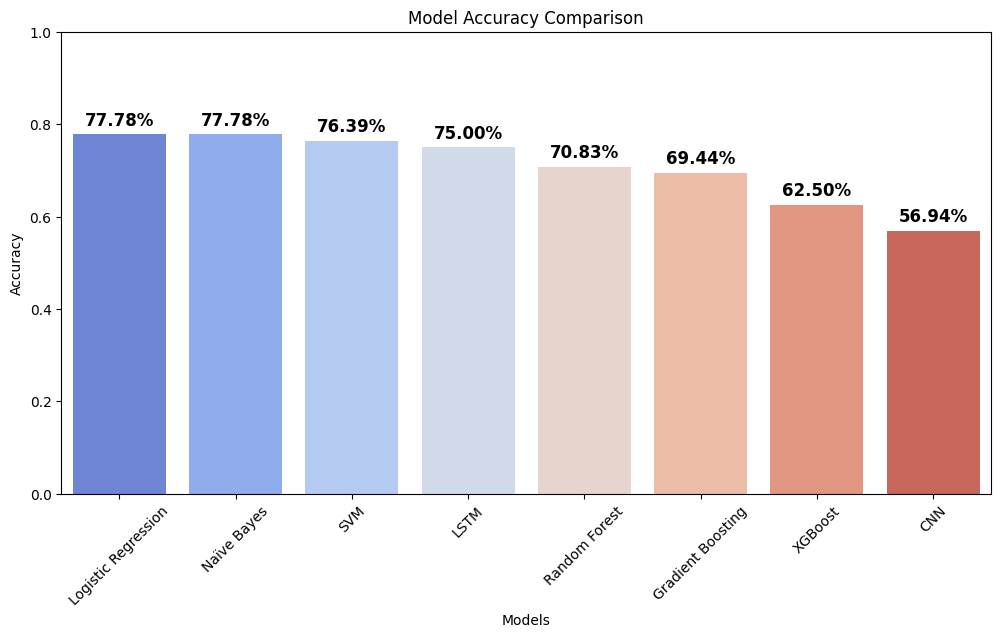

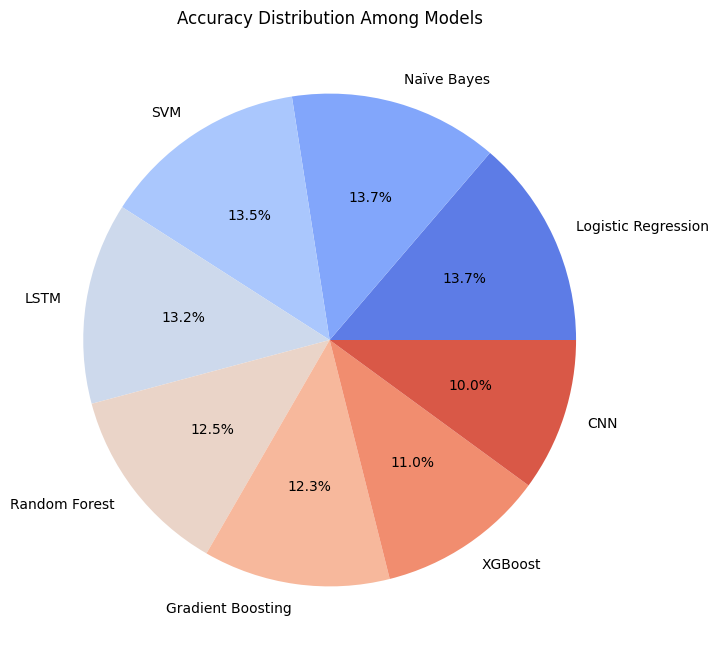

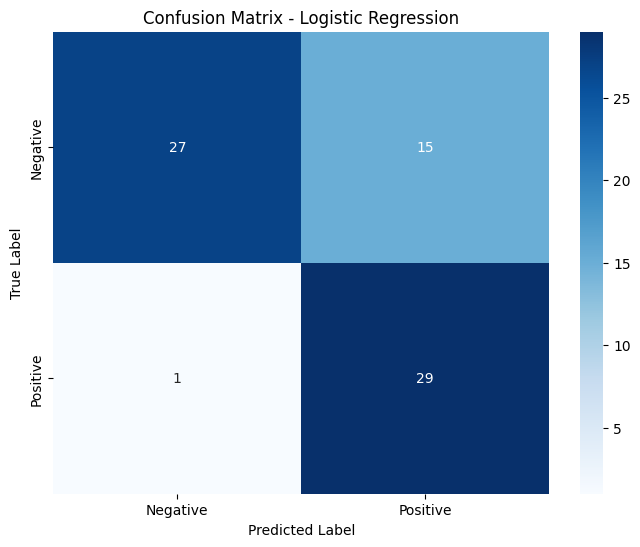

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.96      0.64      0.77        42
           1       0.66      0.97      0.78        30

    accuracy                           0.78        72
   macro avg       0.81      0.80      0.78        72
weighted avg       0.84      0.78      0.78        72



In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Add deep learning models' accuracy
results["LSTM"] = lstm_accuracy
results["CNN"] = cnn_accuracy

# Convert results dictionary to DataFrame
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])

# Sort by accuracy
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Print accuracy table
print("Model Performance:\n", results_df)

### 📌 Bar Chart: Model Accuracy
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Model", y="Accuracy", data=results_df, palette="coolwarm")

# Add accuracy values on bars
for i, value in enumerate(results_df["Accuracy"]):
    ax.text(i, value + 0.02, f"{value:.2%}", ha='center', fontsize=12, fontweight='bold')

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)  # Accuracy between 0 and 1
plt.xticks(rotation=45)
plt.show()

### 📌 Pie Chart: Accuracy Distribution
plt.figure(figsize=(8, 8))
plt.pie(results_df["Accuracy"], labels=results_df["Model"], autopct="%1.1f%%", colors=sns.color_palette("coolwarm", len(results_df)))
plt.title("Accuracy Distribution Among Models")
plt.show()

### 📌 Confusion Matrix for Best Model
best_model_name = results_df.iloc[0, 0]  # Get best model name
best_model = models.get(best_model_name, None)  # Retrieve the best model from dictionary

if best_model:
    y_pred_best = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred_best)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {best_model_name}")
    plt.show()

    # Print classification report
    print(f"Classification Report for {best_model_name}:\n")
    print(classification_report(y_test, y_pred_best))


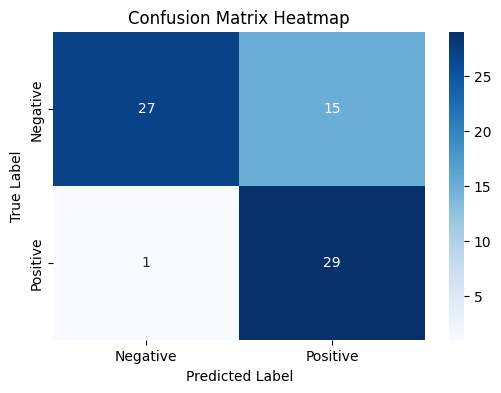

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict using the best model (replace 'best_model' with the actual best-performing model variable)
y_pred = best_model.predict(X_test)

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()


In [3]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df = pd.read_csv("sentiment140.csv", encoding='latin1', names=['target', 'id', 'date', 'flag', 'user', 'text'])
df = df[['target', 'text']]
df['target'] = df['target'].replace({0: 0, 4: 1})  # Convert to binary sentiment (0 = negative, 1 = positive)

# Text Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

df['clean_text'] = df['text'].apply(clean_text)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest with Cross-Validation
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=10, scoring='accuracy')

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Predictions on test set
y_pred = rf_model.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")  # Change binary → weighted
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Cross-Validation Accuracy: 0.6232
Test Accuracy: 0.6400
Precision: 0.6397
Recall: 0.6400
F1 Score: 0.6398


In [8]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Download necessary resources
nltk.download("stopwords")
nltk.download("wordnet")

# Load dataset
df = pd.read_csv("sentiment140.csv", encoding='latin1', names=['target', 'id', 'date', 'flag', 'user', 'text'])
df = df[['target', 'text']]
df['target'] = df['target'].replace({0: 0, 4: 1})  # Convert to binary sentiment (0 = negative, 1 = positive)

# Initialize NLP tools
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Text Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Remove stopwords & lemmatize
    return text

df['clean_text'] = df['text'].apply(clean_text)

# Convert text into Word2Vec embeddings
sentences = [text.split() for text in df['clean_text']]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=2, workers=4)

# Create sentence embeddings by averaging word vectors
def get_embedding(words):
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

X = np.array([get_embedding(words) for words in sentences])
y = df['target']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter tuning for Random Forest
param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

# Train and evaluate
best_rf_model.fit(X_train, y_train)
y_pred = best_rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Best Random Forest Params: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject